In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
words = open('names.txt').read().splitlines()
words[:10], len(words)

(['emma',
  'olivia',
  'ava',
  'isabella',
  'sophia',
  'charlotte',
  'mia',
  'amelia',
  'harper',
  'evelyn'],
 32033)

# E01: train a trigram language model
- Take two characters as an input to predict the 3rd one. 
- Evaluate the loss
- Did it improve over a bigram model?

## Trigrams

In [172]:
from itertools import product

character_set = ["."]
character_set.extend(sorted(list(set("".join(words)))))

input_bigrams = ["".join(x) for x in list(product(character_set, character_set))]
dims = (len(character_set),) * 3
dims

(27, 27, 27)

In [173]:
N = torch.ones(size=dims)
for word in words:
    chs = ["."] + list(word) + ["."]
    for char1, char2, char3 in zip(chs, chs[1:], chs[2:]):
        # print(f"input: {char1 + char2}, output: {char3}")
        i, j, k = (
            character_set.index(char1),
            character_set.index(char2),
            character_set.index(char3),
        )
        N[i, j, k] += 1

In [174]:
# Visualizing is difficult overall, so we only visualize for a given output character, set by `k`
def show_bigrams_for_output(char="."):
    k = character_set.index(char)
    plt.figure(figsize=(24, 24))
    plt.imshow(N[:, :, k], cmap="Oranges")

    for i in range(dims[0]):
        for j in range(dims[1]):
            char_string = f"{character_set[i]}{character_set[j]}"
            # print(char_string)
            plt.text(j, i, char_string, ha="center", va="bottom", color="black")
            plt.text(j, i, N[i, j, k].item(), ha="center", va="top", color="gray")

    plt.axis("off")
    plt.title(f"Trigram counts for output character: {character_set[k]}")

    plt.show()

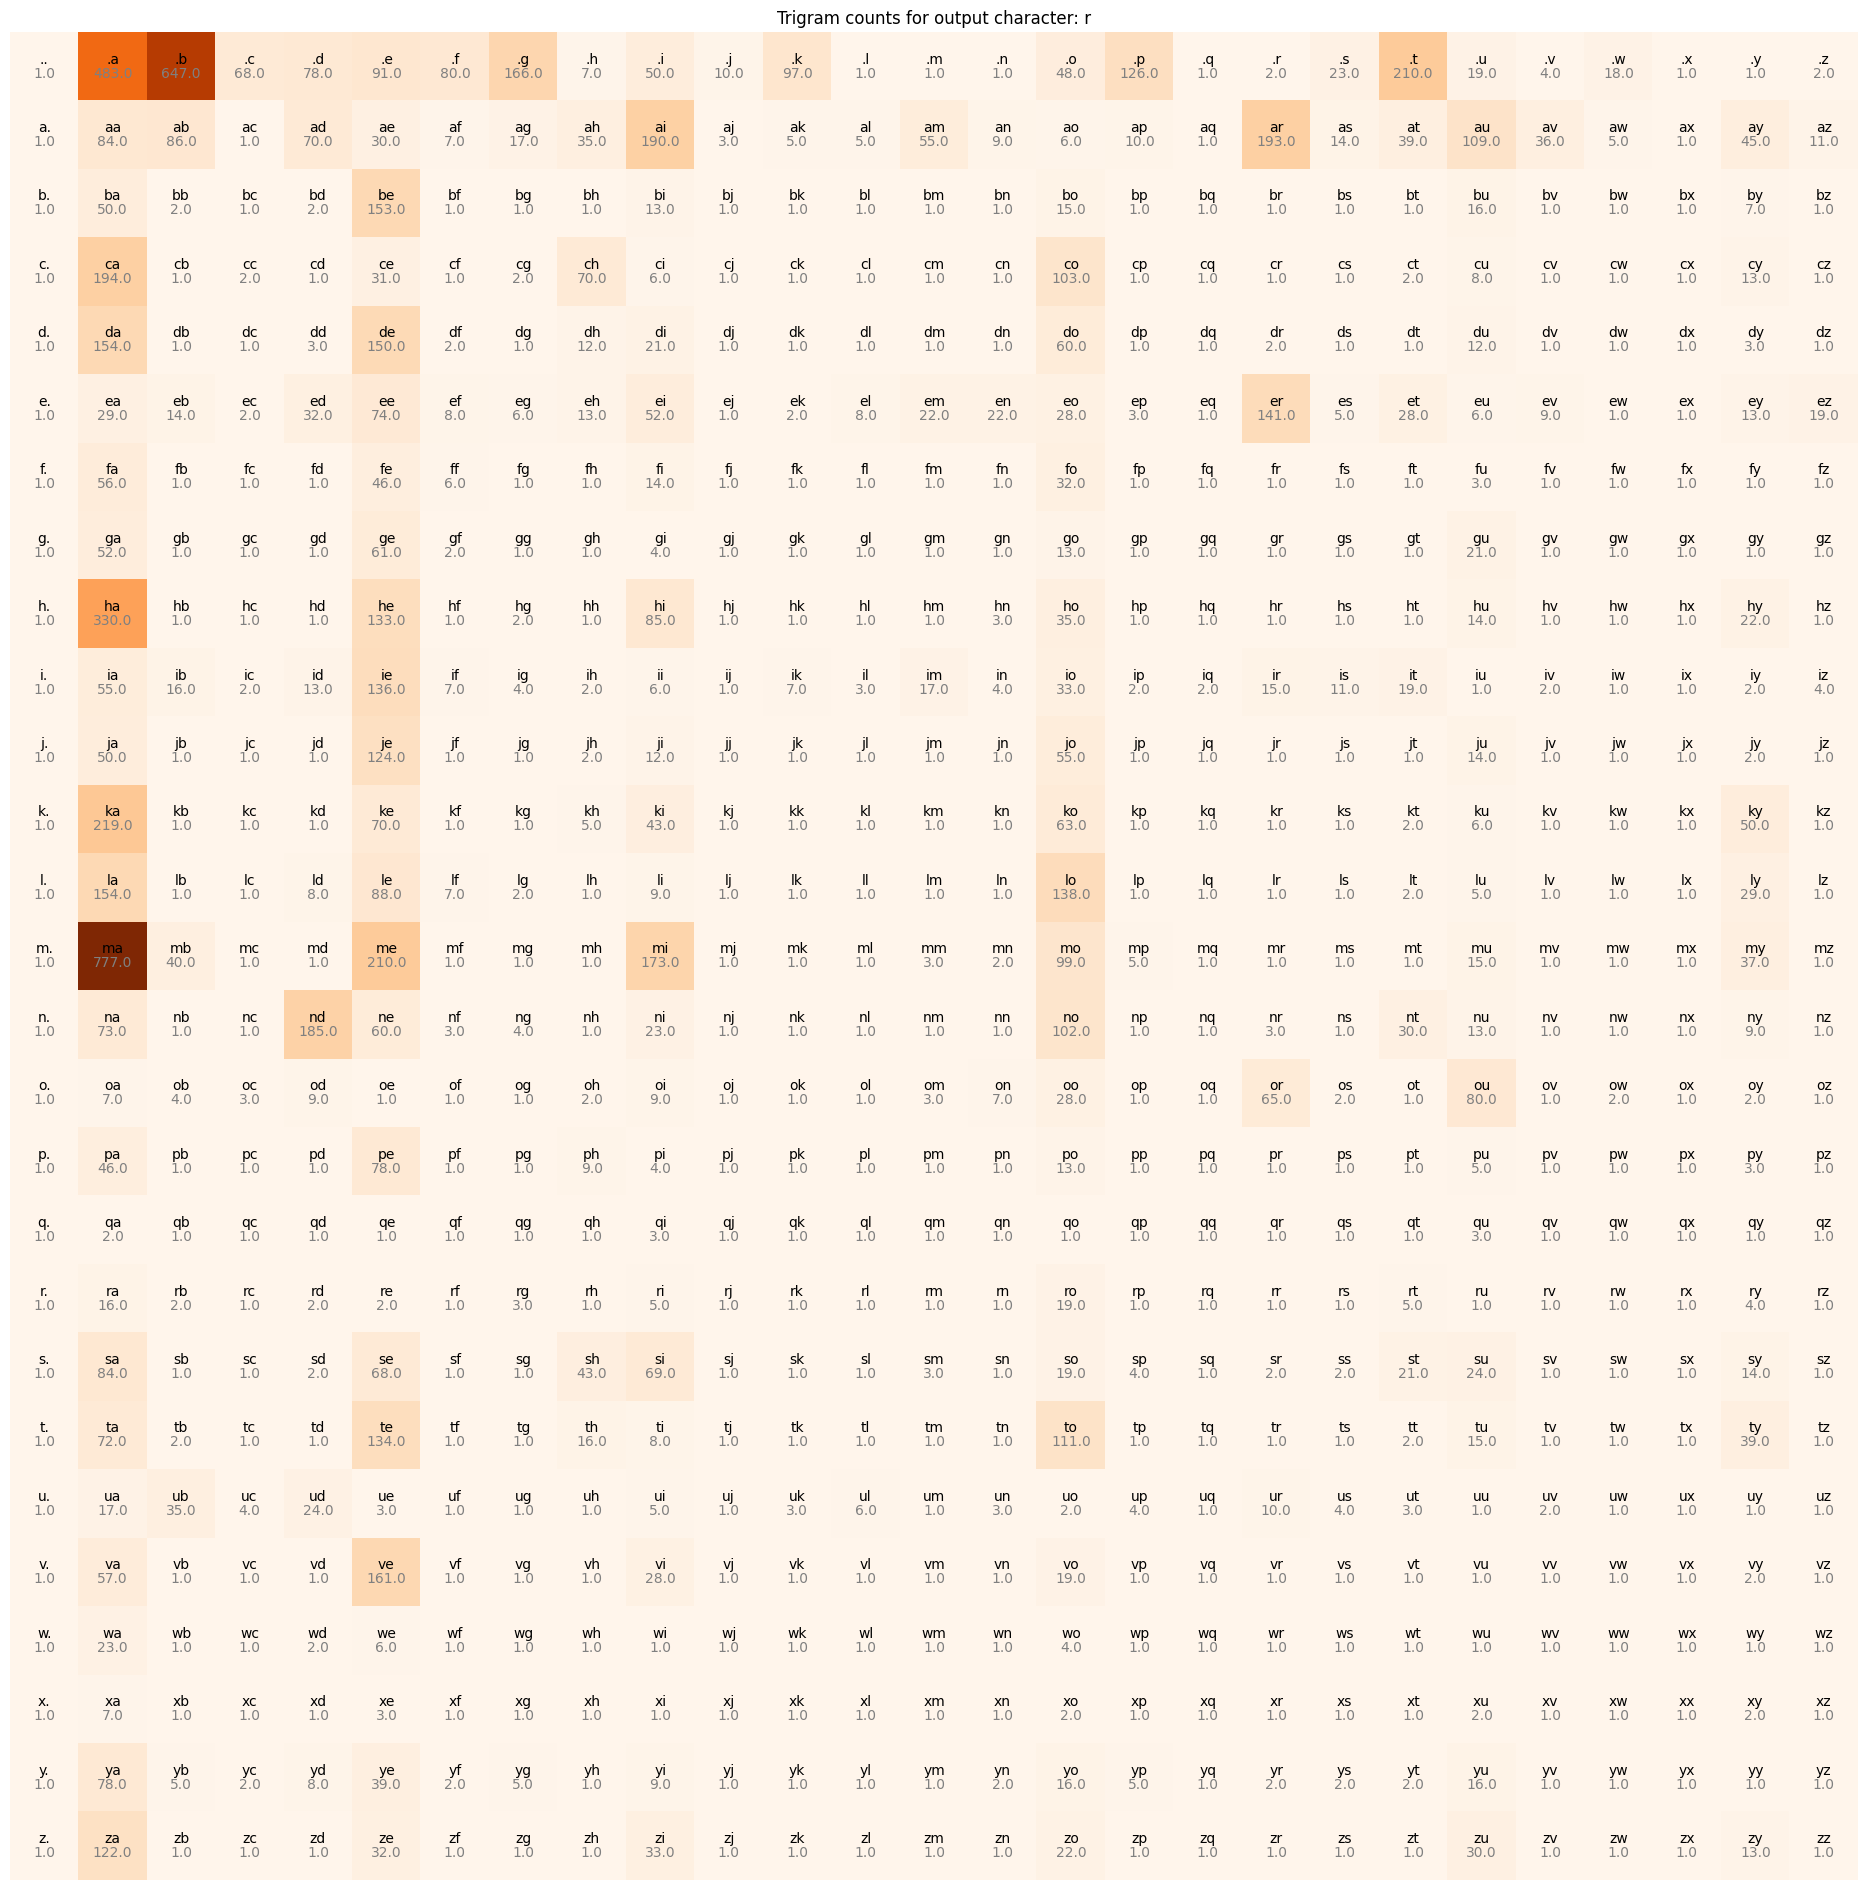

In [175]:
show_bigrams_for_output("r")

In [176]:
bigram = "al"
N.reshape(-1, dims[2])[input_bigrams.index(bigram)]

tensor([176., 354.,  22.,   8.,  55., 602.,   8.,   1.,   9., 576.,   2.,  10.,
        197.,  25.,   1.,  82.,  11.,   1.,   5.,  10.,  28.,  28.,  26.,   5.,
          1., 311.,   1.])

In [177]:
P = N.float()
P /= P.sum(dim=2, keepdim=True)

In [180]:
# Looping over the generation process
g = torch.Generator().manual_seed(42)
for i in range(10):
    bigram = "la"
    generated = [bigram]
    while True:
        i, j = character_set.index(bigram[0]), character_set.index(bigram[1])
        # Get the row of the current character and calculate the probabilities
        p = P[i][j]

        # Sample the next character
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        generated.append(character_set[ix])

        # print(f"Bigram: {bigram}, Sampled character: {character_set[ix]}")

        bigram = bigram[1] + character_set[ix]

        # print(f"Next bigram: {bigram}")

        # Stop if special character is sampled
        if bigram[-1] == ".":
            break

    print("".join(generated))
    print("-" * 100)

laya.
----------------------------------------------------------------------------------------------------
lasyahle.
----------------------------------------------------------------------------------------------------
laimen.
----------------------------------------------------------------------------------------------------
laleekkim.
----------------------------------------------------------------------------------------------------
lang.
----------------------------------------------------------------------------------------------------
lanya.
----------------------------------------------------------------------------------------------------
latryahd.
----------------------------------------------------------------------------------------------------
lairen.
----------------------------------------------------------------------------------------------------
lanna.
----------------------------------------------------------------------------------------------------
la.
--------------

In [31]:
log_likelihood = 0.0
n = 0

for word in words:
    chs = ["."] + list(word) + ["."]
    for char1, char2, char3 in zip(chs, chs[1:], chs[2:]):
        i, j, k = (
            character_set.index(char1),
            character_set.index(char2),
            character_set.index(char3),
        )

        prob = P[i, j, k]
        logprob = torch.log(prob)

        log_likelihood += logprob
        n += 1

        # print(f"{char1}{char2} -> {char3}, {prob:.4f} {logprob:.4f}")

print(f"{log_likelihood=}")
print(f"NLL: {-log_likelihood=}")
print(f"Average NLL: {-log_likelihood/n}")

log_likelihood=tensor(-410414.9688)
NLL: -log_likelihood=tensor(410414.9688)
Average NLL: 2.092747449874878


### Using `torch.nn`

In [237]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

xs = []
ys = []

for word in words:
    chs = ["."] + list(word) + ["."]
    for char1, char2, char3 in zip(chs, chs[1:], chs[2:]):
        # print(f"input: {char1 + char2}, output: {char3}")
        i, j, k = (
            character_set.index(char1),
            character_set.index(char2),
            character_set.index(char3),
        )

        xs.append([i, j])
        ys.append(k)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_examples = xs.shape[0]

print(f"{num_examples=}")

g = torch.Generator(device=device).manual_seed(42)
# Weight matrix will be of size [input string, output string] = [bigram, character] = [27*2, 27]
W = torch.randn(
    size=(len(character_set) * 2, len(character_set)),
    generator=g,
    requires_grad=True,
    device=device,
).float()

num_examples=196113


In [238]:
xs.shape, ys.shape, W.shape

(torch.Size([196113, 2]), torch.Size([196113]), torch.Size([54, 27]))

In [185]:
# ------
# Manual version, needs refactoring to work
# -----

# nlls = torch.zeros(len(xs))

# for i in range(len(xs)):
#     x = xs[i]
#     y = ys[i]

#     print("-" * 10)
#     print(
#         f'Bigram example {i+1}: "{character_set[x[0]]}{character_set[x[1]]}", {x=}, {y=}'
#     )
#     print(f"Input to NN: {x}")
#     print(f"Output probabilities: {probs[i]}")
#     print(f"Actual next character: {y}")

#     p = probs[i, y]
#     print(f"Probability assigned to actual next character: {p}")
#     logp = torch.log(p)
#     print(f"Log-probability assigned to actual next character: {logp}")
#     nll = -logp
#     print(f"NLL: {nll}")

#     nlls[i] = nll

# print("=" * 100)
# print(f"Average NLL: {nlls.mean()}")

In [239]:
learning_rate = 1e1
epochs = 300
alpha = 1e-3

for epoch in range(epochs):
    # We need to one-hot encode the input bigrams and reshape them to be of size [batch, bigram]
    x_enc = (
        F.one_hot(xs, num_classes=len(character_set))
        .float()
        .reshape(-1, len(character_set) * 2)
        .to(device)
    )
    logits = x_enc @ W
    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    # Calculate the loss with regularization
    loss = (
        probs[torch.arange(num_examples), ys].log().neg().mean()
        + alpha * (W**2).mean()
    )

    # Calculate the gradients
    W.grad = None
    loss.backward()

    # Update the weights
    W.data += -learning_rate * W.grad

    if epoch % 10 == 0:
        print(f"{epoch=}, {loss=}")

epoch=0, loss=tensor(4.0478, device='cuda:0', grad_fn=<AddBackward0>)
epoch=10, loss=tensor(3.0823, device='cuda:0', grad_fn=<AddBackward0>)
epoch=20, loss=tensor(2.7672, device='cuda:0', grad_fn=<AddBackward0>)
epoch=30, loss=tensor(2.6234, device='cuda:0', grad_fn=<AddBackward0>)
epoch=40, loss=tensor(2.5413, device='cuda:0', grad_fn=<AddBackward0>)
epoch=50, loss=tensor(2.4879, device='cuda:0', grad_fn=<AddBackward0>)
epoch=60, loss=tensor(2.4504, device='cuda:0', grad_fn=<AddBackward0>)
epoch=70, loss=tensor(2.4225, device='cuda:0', grad_fn=<AddBackward0>)
epoch=80, loss=tensor(2.4009, device='cuda:0', grad_fn=<AddBackward0>)
epoch=90, loss=tensor(2.3837, device='cuda:0', grad_fn=<AddBackward0>)
epoch=100, loss=tensor(2.3697, device='cuda:0', grad_fn=<AddBackward0>)
epoch=110, loss=tensor(2.3580, device='cuda:0', grad_fn=<AddBackward0>)
epoch=120, loss=tensor(2.3482, device='cuda:0', grad_fn=<AddBackward0>)
epoch=130, loss=tensor(2.3398, device='cuda:0', grad_fn=<AddBackward0>)
epo

In [244]:
# Predicting the next character
g = torch.Generator(device=device).manual_seed(42)

inputs = [".", "la", "ru", "ke", "yi"]


for b in inputs:
    print("=" * 100)
    print(f"{b=}")
    print("=" * 100)
    for i in range(10):
        bigram = b
        generated = [bigram]

        while True:
            xs = torch.tensor(
                [character_set.index(bigram[i]) for i in range(len(bigram))]
            )

            x_enc = (
                F.one_hot(xs, num_classes=len(character_set))
                .float()
                .reshape(-1, len(character_set) * 2)
                .to(device)
            )
            logits = x_enc @ W
            counts = logits.exp()
            probs = counts / counts.sum(dim=1, keepdim=True)

            # Sample the next character
            ix = torch.multinomial(probs, 1, replacement=True, generator=g).item()
            generated.append(character_set[ix])

            # print(f"Bigram: {bigram}, Sampled character: {character_set[ix]}")

            bigram = bigram[1] + character_set[ix]

            # print(f"Next bigram: {bigram}")

            # Stop if special character is sampled
            if bigram[-1] == ".":
                break

        print("".join(generated))

b='.e'
.el.
.eitarikaviranoe.
.ed.
.edar.
.eer.
.er.
.emairishiionaikellive.
.erthis.
.elousgemie.
.ewysileonony.
b='la'
lanusinaver.
la.
lai.
lahmin.
laviestona.
lair.
lawlay.
lavancevistwritqurie.
layle.
laydi.
b='ru'
ruh.
rudi.
ruh.
rumtra.
ruepayarrye.
rutrey.
rujneykegtahyn.
ruza.
ruri.
rue.
b='ke'
keggee.
ken.
keshalia.
kens.
keidammarith.
kely.
kevge.
kerilan.
kemtrnelekellaylail.
ke.
b='yi'
yi.
yi.
yina.
yi.
yis.
yisennas.
yishgkal.
yin.
yi.
yiah.


# E02: split up the dataset randomly
- Into 80% train set, 10% dev set, 10% test set
- Train the bigram and trigram models only on the training set. 
- Evaluate them on dev and test splits. What can you see?


# E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful.
- Can you delete our use of F.one_hot in favor of simply indexing into rows of W?

In [296]:
# Creating the training set of bigrams (x, y)
character_set = ["."]
character_set.extend(sorted(list(set("".join(words)))))

s_to_i = {s: i for i, s in enumerate(character_set)}
i_to_s = {i: s for s, i in s_to_i.items()}

dims = len(character_set)

In [299]:
xs, ys = [], []

for word in words:
    chs = ["."] + list(word) + ["."]
    for c1, c2 in zip(chs, chs[1:]):
        # print(c1, c2)
        i, j = s_to_i[c1], s_to_i[c2]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_examples = xs.nelement()
print(f"Number of examples: {num_examples}")

# Initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((dims, dims), generator=g, requires_grad=True)

Number of examples: 228146


In [300]:
learning_rate = 50

for k in range(200):
    logits = W[xs]

    counts = logits.exp()
    probs = counts / counts.sum(dim=1, keepdim=True)

    loss = (
        probs[torch.arange(num_examples), ys].log().neg().mean()
        + 1e-2 * (W**2).mean()
    )

    W.grad = None
    loss.backward()

    W.data += -learning_rate * W.grad

    print(f"Iteration {k}: {loss.item()}")

Iteration 0: 3.7686190605163574
Iteration 1: 3.378791332244873
Iteration 2: 3.161083459854126
Iteration 3: 3.02718186378479
Iteration 4: 2.9344801902770996
Iteration 5: 2.8672285079956055
Iteration 6: 2.816652774810791
Iteration 7: 2.7771458625793457
Iteration 8: 2.745253562927246
Iteration 9: 2.7188305854797363
Iteration 10: 2.6965057849884033
Iteration 11: 2.6773722171783447
Iteration 12: 2.6608052253723145
Iteration 13: 2.6463515758514404
Iteration 14: 2.6336653232574463
Iteration 15: 2.622471570968628
Iteration 16: 2.6125471591949463
Iteration 17: 2.6037065982818604
Iteration 18: 2.595794439315796
Iteration 19: 2.5886807441711426
Iteration 20: 2.5822560787200928
Iteration 21: 2.5764293670654297
Iteration 22: 2.5711236000061035
Iteration 23: 2.566272735595703
Iteration 24: 2.5618226528167725
Iteration 25: 2.5577261447906494
Iteration 26: 2.5539438724517822
Iteration 27: 2.550442695617676
Iteration 28: 2.5471925735473633
Iteration 29: 2.5441696643829346
Iteration 30: 2.54135251045227

In [301]:
# Predicting the next character
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix = 0
    out = [i_to_s[ix]]
    
    while True:
        # print(f"Input character: {x}")
        # print(f"Probabilities: {probs[x]}")

        logits = W[ix].unsqueeze(0)

        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(
            probs, 1, replacement=True, generator=g
        ).item()
        out.append(i_to_s[ix])

        # print(f"Predicted next character: {next_char}")

        if ix == 0:
            break

    print("=" * 100)
    print("".join(out))

.junide.
.janasah.
.prelay.
.a.
.nn.


# E05: look up and use F.cross_entropy instead
- You should achieve the same result. 
- Can you think of why we'd prefer to use F.cross_entropy instead?


In [307]:
xs, ys = [], []

for word in words:
    chs = ["."] + list(word) + ["."]
    for c1, c2 in zip(chs, chs[1:]):
        # print(c1, c2)
        i, j = s_to_i[c1], s_to_i[c2]
        xs.append(i)
        ys.append(j)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num_examples = xs.nelement()
print(f"Number of examples: {num_examples}")

# Initialize the network
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((dims, dims), generator=g, requires_grad=True)


Number of examples: 228146


In [309]:
learning_rate = 50

for k in range(200):
    logits = W[xs]

    # counts = logits.exp()
    # probs = counts / counts.sum(dim=1, keepdim=True)

    loss = F.cross_entropy(logits, ys) + 1e-2 * (W**2).mean()

    W.grad = None
    loss.backward()

    W.data += -learning_rate * W.grad

    if k % 10 == 0:
        print(f"Iteration {k}: {loss.item()}")

Iteration 0: 3.768618583679199
Iteration 10: 2.696505546569824
Iteration 20: 2.5822560787200928
Iteration 30: 2.5413522720336914
Iteration 40: 2.52126407623291
Iteration 50: 2.509855031967163
Iteration 60: 2.502706289291382
Iteration 70: 2.4978790283203125
Iteration 80: 2.494438648223877
Iteration 90: 2.4918932914733887
Iteration 100: 2.4899590015411377
Iteration 110: 2.4884583950042725
Iteration 120: 2.4872729778289795
Iteration 130: 2.486323118209839
Iteration 140: 2.4855518341064453
Iteration 150: 2.484917163848877
Iteration 160: 2.484389066696167
Iteration 170: 2.4839460849761963
Iteration 180: 2.483569622039795
Iteration 190: 2.4832472801208496


In [ ]:
# Predicting the next character
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    ix = 0
    out = [i_to_s[ix]]
    
    while True:
        # print(f"Input character: {x}")
        # print(f"Probabilities: {probs[x]}")

        logits = W[ix].unsqueeze(0)

        counts = logits.exp()
        probs = counts / counts.sum(dim=1, keepdim=True)

        ix = torch.multinomial(
            probs, 1, replacement=True, generator=g
        ).item()
        out.append(i_to_s[ix])

        # print(f"Predicted next character: {next_char}")

        if ix == 0:
            break

    print("=" * 100)
    print("".join(out))